In [50]:
import SimpleITK as sitk
import numpy as np

CT_data = sitk.ReadImage("CT_Steel.nii")
paut = sitk.ReadImage("SAFT1_3.nii")



# Get the size, origin, and spacing for CT_data
CT_size = CT_data.GetSize()
CT_origin = CT_data.GetOrigin()
CT_spacing = CT_data.GetSpacing()

# Get the size, origin, and spacing for paut
paut_size = paut.GetSize()
paut_origin = paut.GetOrigin()
paut_spacing = paut.GetSpacing()

# Print the details
print("CT Data:")
print("Size:", CT_size)
print("Origin:", CT_origin)
print("Spacing:", CT_spacing)

print("\nPAUT Data:")
print("Size:", paut_size)
print("Origin:", paut_origin)
print("Spacing:", paut_spacing)

CT Data:
Size: (384, 1024, 384)
Origin: (0.0, 0.0, 0.0)
Spacing: (1.0, 1.0, 1.0)

PAUT Data:
Size: (240, 1700, 49)
Origin: (-233.0, -898.0, 120.0)
Spacing: (0.3499999940395355, 0.4000000059604645, 2.9800000190734863)


In [52]:
def resample_image_to_reference(input_image, reference_image):
    """
    Resample the input_image to match the reference_image's physical space.
    """
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference_image)
    resample.SetInterpolator(sitk.sitkLinear)  # Use linear interpolation
    resample.SetDefaultPixelValue(0)  # Value for out-of-bounds pixels
    resample.SetOutputOrigin(reference_image.GetOrigin())
    resample.SetOutputSpacing(reference_image.GetSpacing())
    resample.SetSize(reference_image.GetSize())
    resample.SetOutputDirection(reference_image.GetDirection())
    return resample.Execute(input_image)

# Resample the PAUT image to match the CT image
resampled_paut = resample_image_to_reference(paut, CT_data)
paut_size = resampled_paut.GetSize()
paut_origin = resampled_paut.GetOrigin()
paut_spacing = resampled_paut.GetSpacing()

print(paut_size)
print(paut_origin)
print(paut_spacing)



(384, 1024, 384)
(0.0, 0.0, 0.0)
(1.0, 1.0, 1.0)


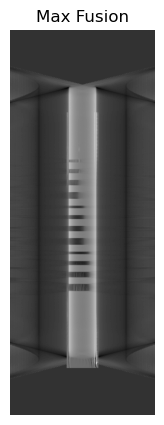

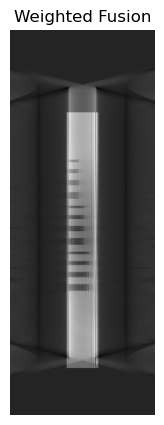

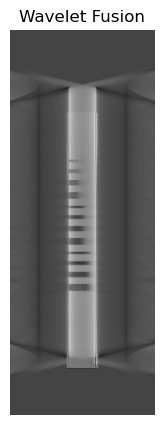

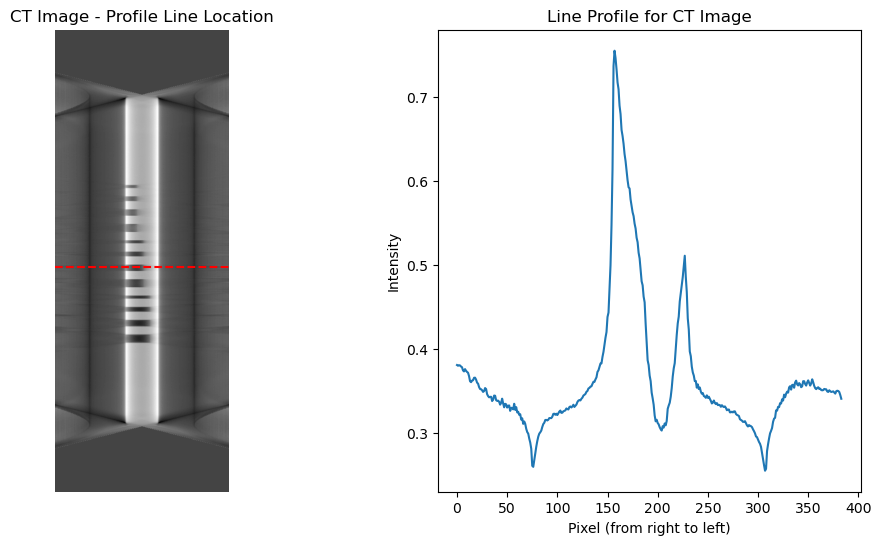

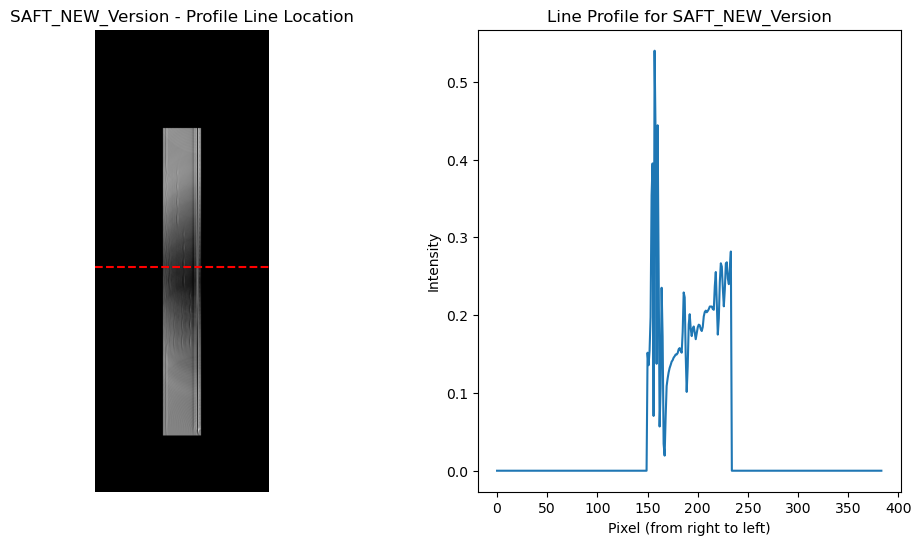

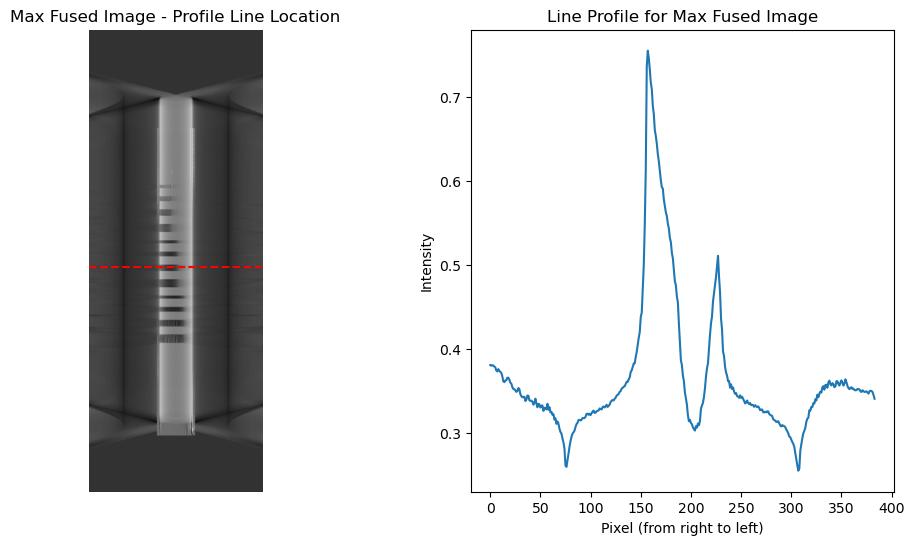

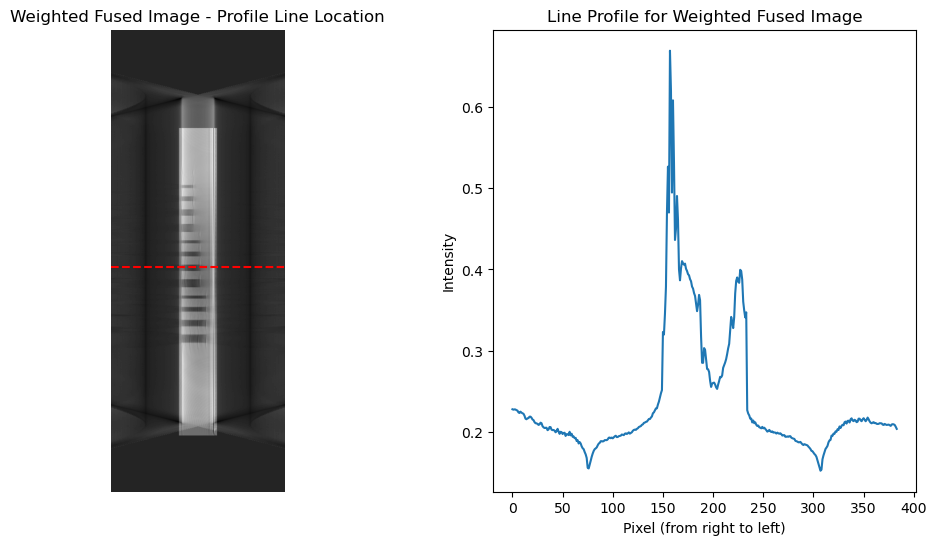

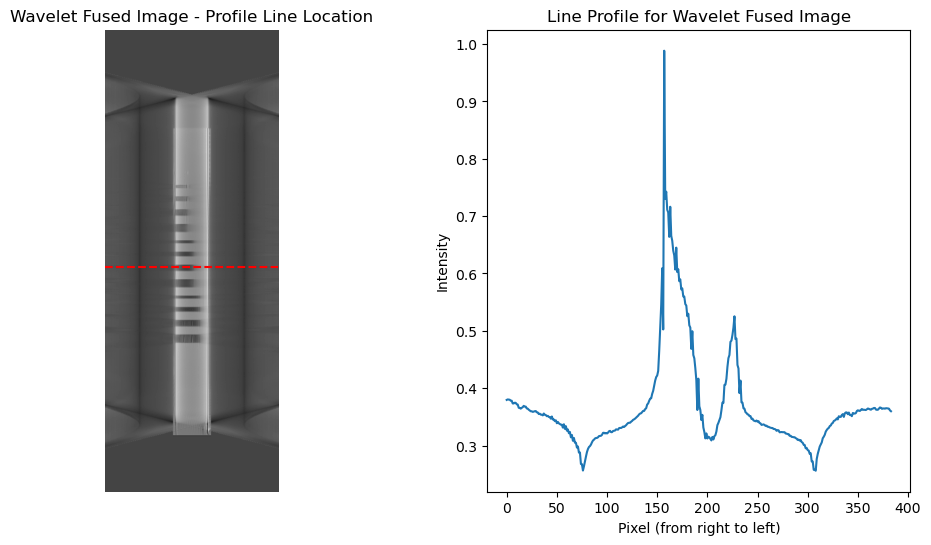

In [54]:
import SimpleITK as sitk
import numpy as np
import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def maximum_fusion(ct_image, paut_image):
    """Apply pixel-wise maximum fusion."""
    return sitk.Maximum(ct_image, paut_image)

def weighted_fusion(ct_image, paut_image, alpha=0.6):
    """Apply weighted averaging fusion: output = alpha * CT + (1-alpha) * PAUT"""
    return sitk.Add(sitk.Multiply(ct_image, alpha), sitk.Multiply(paut_image, (1 - alpha)))

def wavelet_fusion(ct_image, paut_image, wavelet='haar'):
    """Wavelet-based fusion using maximum selection of wavelet coefficients."""
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)

    # Wavelet decomposition
    coeffs_ct = pywt.dwtn(ct_array, wavelet)
    coeffs_paut = pywt.dwtn(paut_array, wavelet)

    # Fusion by maximum selection
    fused_coeffs = {}
    for key in coeffs_ct.keys():
        fused_coeffs[key] = np.maximum(coeffs_ct[key], coeffs_paut[key])

    # Inverse wavelet transform
    fused_array = pywt.idwtn(fused_coeffs, wavelet)
    return sitk.GetImageFromArray(fused_array)

def save_image(image, output_path):
    """Save SimpleITK image to a file."""
    sitk.WriteImage(image, output_path)

def display_fused_image(fused, title='Fused Image', save_path=None):
    """Display the final fused image and optionally save it as PNG."""
    # Get the middle slice of the fused image
    fused_array = sitk.GetArrayFromImage(fused)[fused.GetSize()[2]//2]
    plt.figure(figsize=(5,5))
    plt.imshow(fused_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, save_path=None):
    """
    Plot line profile (from right to left) for the given image.
    This function extracts the middle row of the middle slice, reverses it,
    and displays the line on the image where the profile was taken.
    Optionally, the figure is saved as a PNG file.
    """
    array = sitk.GetArrayFromImage(image)
    # Get the middle slice
    mid_slice_index = array.shape[0] // 2
    mid_slice = array[mid_slice_index]
    # Get the middle row of that slice
    mid_row_index = 525
    mid_row = mid_slice[mid_row_index]
    # Extract the line profile from right to left
    line_profile = mid_row[::-1]

    # Create a figure with two subplots: one for the image with line overlay and one for the profile plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the middle slice with the profile line overlaid
    axs[0].imshow(mid_slice, cmap='gray')
    axs[0].axhline(y=mid_row_index, color='red', linestyle='--')
    axs[0].set_title(f'{label} - Profile Line Location')
    axs[0].axis('off')

    # Plot the line profile
    axs[1].plot(line_profile)
    axs[1].set_title(f'Line Profile for {label}')
    axs[1].set_xlabel('Pixel (from right to left)')
    axs[1].set_ylabel('Intensity')

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Example usage:
    # Assume CT_data and resampled_paut are your input SimpleITK images.
    
    # Normalize images to [0,1]
    ct_image = normalize_image(CT_data)
    paut_image = normalize_image(resampled_paut)

    # Apply fusion techniques
    max_fused = maximum_fusion(ct_image, paut_image)
    weighted_fused = weighted_fusion(ct_image, paut_image, alpha=0.6)
    wavelet_fused = wavelet_fusion(ct_image, paut_image)

    # Save fused images as NIfTI files
    save_image(max_fused, "max_fused.nii")
    save_image(weighted_fused, "weighted_fused.nii")
    save_image(wavelet_fused, "wavelet_fused.nii")

    # Display only the fused images and save as PNG
    display_fused_image(max_fused, title='Max Fusion', save_path='max_fused.png')
    display_fused_image(weighted_fused, title='Weighted Fusion', save_path='weighted_fused.png')
    display_fused_image(wavelet_fused, title='Wavelet Fusion', save_path='wavelet_fused.png')

    # Plot line profiles for each image and save as PNG files
    plot_line_profile(ct_image, "CT Image", save_path='ct_line_profile.png')
    plot_line_profile(paut_image, "SAFT_NEW_Version", save_path='SAFT_NEW_Version.png')
    plot_line_profile(max_fused, "Max Fused Image", save_path='max_fused_line_profile.png')
    plot_line_profile(weighted_fused, "Weighted Fused Image", save_path='weighted_fused_line_profile.png')
    plot_line_profile(wavelet_fused, "Wavelet Fused Image", save_path='wavelet_fused_line_profile.png')


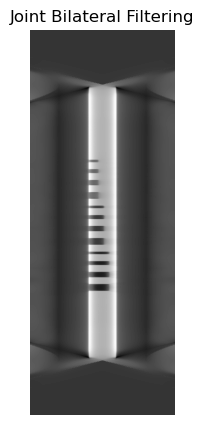

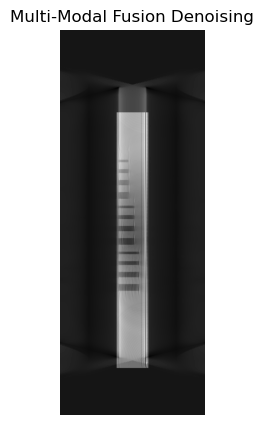

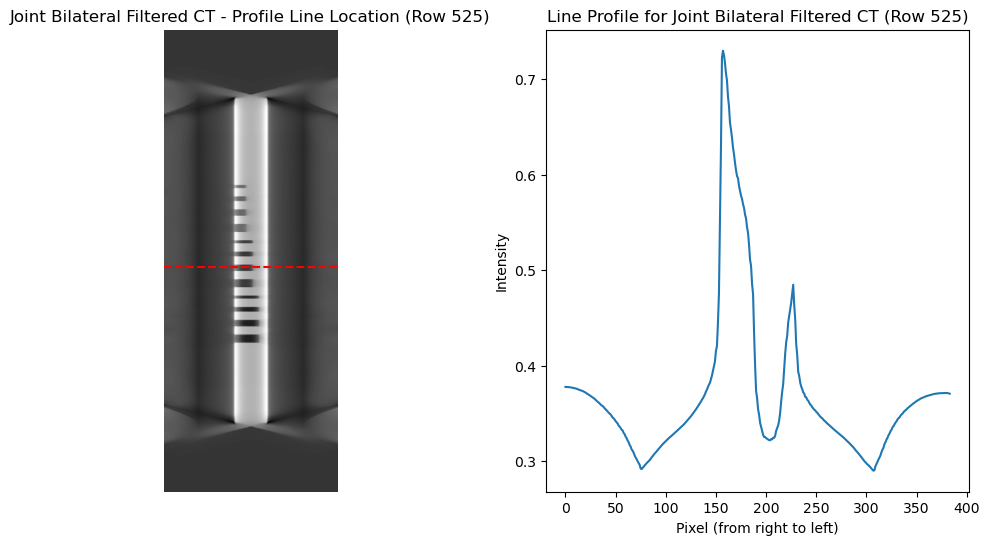

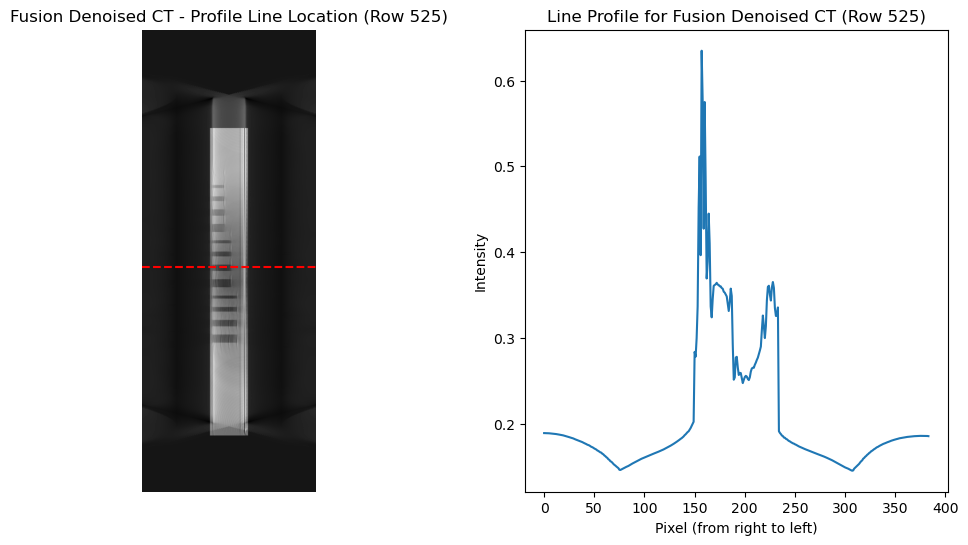

In [56]:
import SimpleITK as sitk
import numpy as np
import pywt
import matplotlib.pyplot as plt

def load_image(file_path):
    """Load a SimpleITK image from file."""
    return sitk.ReadImage(file_path)

def normalize_image(image):
    """Normalize image intensities to range [0,1]."""
    array = sitk.GetArrayFromImage(image)
    array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return sitk.GetImageFromArray(array)

def cast_to_int(image, pixel_type=sitk.sitkUInt16):
    """Cast image to integer type (UInt16) for compatibility with Mask operations."""
    return sitk.Cast(image, pixel_type)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    This returns a 2D image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    # Set the size for the extraction: full in x and y, but only 0 in the z-direction.
    size[2] = 0  
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

# --- Joint Bilateral Filtering ---
def joint_bilateral_filter(ct_image, paut_image, sigma_color=0.05, sigma_space=10):
    """Apply joint bilateral filtering using PAUT as guidance."""
    bilateral_filter = sitk.BilateralImageFilter()
    bilateral_filter.SetDomainSigma(sigma_space)
    bilateral_filter.SetRangeSigma(sigma_color)
    return bilateral_filter.Execute(ct_image)

# --- Multi-Modal Noise Reduction via Fusion ---
def multimodal_fusion_denoising(filtered_ct_image, paut_image):
    """
    Apply wavelet-based noise reduction by fusing PAUT guidance.
    Here, the filtered CT image from the joint bilateral filter is fused with the PAUT slice.
    """
    ct_array = sitk.GetArrayFromImage(filtered_ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    coeffs_ct = pywt.dwtn(ct_array, 'haar')
    coeffs_paut = pywt.dwtn(paut_array, 'haar')
    fused_coeffs = {key: (coeffs_ct[key] + coeffs_paut[key]) / 2 for key in coeffs_ct.keys()}
    denoised_array = pywt.idwtn(fused_coeffs, 'haar')
    return sitk.GetImageFromArray(denoised_array)

# --- Display Function for Filtered Image ---
def display_filtered_image(filtered, title='Filtered Image', save_path=None):
    """Display only the final filtered image (2D slice) and optionally save as PNG."""
    filtered_array = sitk.GetArrayFromImage(filtered)
    plt.figure(figsize=(5,5))
    plt.imshow(filtered_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, save_path=None):
    """
    Plot a line profile (from right to left) for the given 2D image.
    This function extracts the row at index 525, reverses it,
    and displays the line on the image where the profile was taken.
    Optionally, the figure is saved as a PNG file.
    """
    array = sitk.GetArrayFromImage(image)
    row_index = 525
    if row_index >= array.shape[0]:
        raise ValueError("The image does not have a row at index 525.")
    row_data = array[row_index]
    line_profile = row_data[::-1]

    # Create a figure with two subplots: one for the image with line overlay and one for the profile plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the 2D image with the profile line overlaid
    axs[0].imshow(array, cmap='gray')
    axs[0].axhline(y=row_index, color='red', linestyle='--')
    axs[0].set_title(f'{label} - Profile Line Location (Row 525)')
    axs[0].axis('off')
    
    # Plot the line profile
    axs[1].plot(line_profile)
    axs[1].set_title(f'Line Profile for {label} (Row 525)')
    axs[1].set_xlabel('Pixel (from right to left)')
    axs[1].set_ylabel('Intensity')

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # Assume CT_data and resampled_paut are previously loaded 3D images.
    
    # Normalize full volumes
    ct_normalized = normalize_image(CT_data)
    paut_normalized = normalize_image(resampled_paut)
    
    # Extract middle slice from each volume (2D images)
    ct_slice = extract_middle_slice(ct_normalized)
    paut_slice = extract_middle_slice(paut_normalized)
    
    # Apply joint bilateral filtering first
    bilateral_filtered = joint_bilateral_filter(ct_slice, paut_slice)
    
    # Then apply multi-modal fusion denoising using the bilateral filtered result and PAUT slice
    fusion_filtered = multimodal_fusion_denoising(bilateral_filtered, paut_slice)
    
    # Display final filtered images only and save as PNG
    display_filtered_image(bilateral_filtered, title='Joint Bilateral Filtering', save_path='joint_bilateral_filter.png')
    display_filtered_image(fusion_filtered, title='Multi-Modal Fusion Denoising', save_path='fusion_denoised.png')
    
    # Plot line profiles for original and filtered images and save as PNG files
    plot_line_profile(bilateral_filtered, "Joint Bilateral Filtered CT", save_path='joint_bilateral_line_profile.png')
    plot_line_profile(fusion_filtered, "Fusion Denoised CT", save_path='fusion_denoised_line_profile.png')


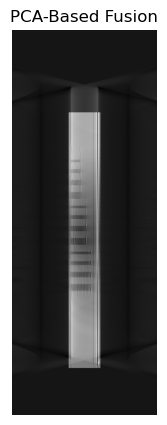

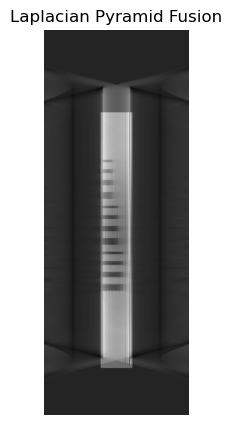

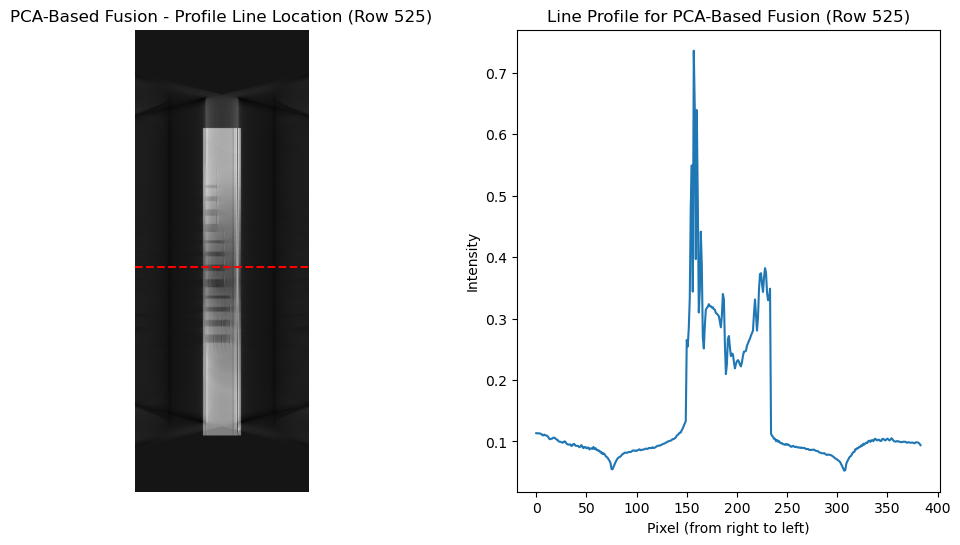

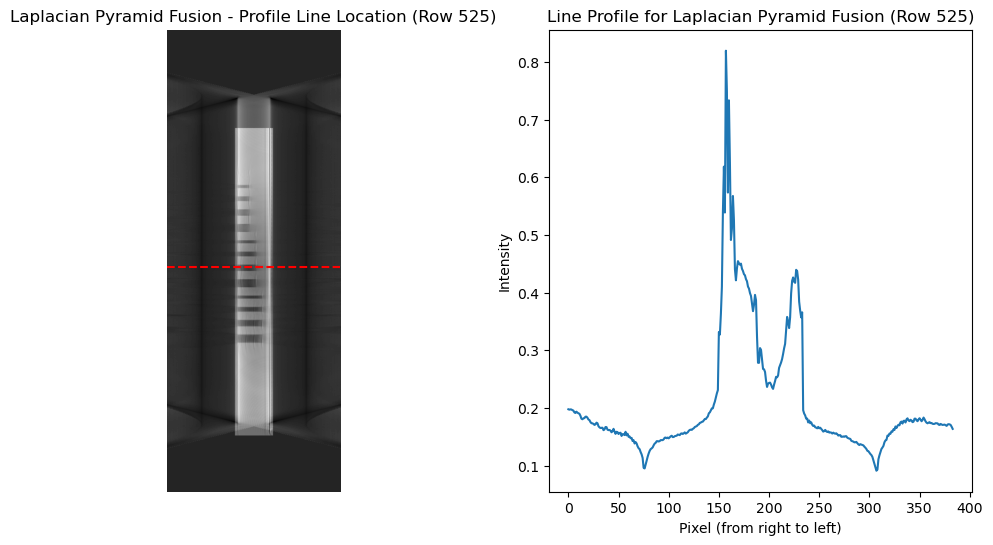

In [58]:
import SimpleITK as sitk
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

def normalize_image(image):
    """Normalize image intensities to range [0,1] and return a SimpleITK image."""
    array = sitk.GetArrayFromImage(image)
    normalized_array = (array - np.min(array)) / (np.max(array) - np.min(array))
    normalized_image = sitk.GetImageFromArray(normalized_array)
    return sitk.Cast(normalized_image, sitk.sitkFloat32)

def extract_middle_slice(image):
    """
    Extract the middle slice from a 3D image using SimpleITK's ExtractImageFilter.
    Returns a 2D SimpleITK image.
    """
    size = list(image.GetSize())
    index = [0, 0, size[2] // 2]
    size[2] = 0  # extract only one slice along the z-direction
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    return extractor.Execute(image)

def pca_fusion(ct_image, paut_image):
    """
    Fuse two modalities using a PCA-based approach.
    """
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)
    
    pixels = np.stack((ct_array.flatten(), paut_array.flatten()), axis=1)
    mean = np.mean(pixels, axis=0)
    centered = pixels - mean
    cov = np.cov(centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    principal_component = eigvecs[:, np.argmax(eigvals)]
    fused_flat = np.dot(centered, principal_component)
    
    fused_array = fused_flat.reshape(ct_array.shape)
    fused_array = (fused_array - np.min(fused_array)) / (np.max(fused_array) - np.min(fused_array))
    return sitk.GetImageFromArray(fused_array)

def laplacian_pyramid_fusion(ct_image, paut_image, levels=3, sigma=1.0, weight=0.5):
    """
    Fuse two modalities using Laplacian pyramid fusion.
    """
    ct_array = sitk.GetArrayFromImage(ct_image)
    paut_array = sitk.GetArrayFromImage(paut_image)

    def gaussian_pyramid(image_array, levels, sigma):
        gp = [image_array]
        for _ in range(1, levels):
            image_array = ndimage.gaussian_filter(image_array, sigma=sigma)
            image_array = image_array[::2, ::2]
            gp.append(image_array)
        return gp

    def laplacian_pyramid(gp):
        lp = []
        for i in range(len(gp) - 1):
            expanded = ndimage.zoom(gp[i + 1], zoom=2, order=1)
            if expanded.shape != gp[i].shape:
                expanded = expanded[:gp[i].shape[0], :gp[i].shape[1]]
            lp.append(gp[i] - expanded)
        lp.append(gp[-1])
        return lp

    def reconstruct_from_laplacian(lp):
        image = lp[-1]
        for l in reversed(lp[:-1]):
            image = ndimage.zoom(image, zoom=2, order=1)
            if image.shape != l.shape:
                image = image[:l.shape[0], :l.shape[1]]
            image = image + l
        return image

    gp_ct = gaussian_pyramid(ct_array, levels, sigma)
    gp_paut = gaussian_pyramid(paut_array, levels, sigma)

    lp_ct = laplacian_pyramid(gp_ct)
    lp_paut = laplacian_pyramid(gp_paut)

    fused_lp = [weight * l_ct + (1 - weight) * l_paut for l_ct, l_paut in zip(lp_ct, lp_paut)]
    
    fused_array = reconstruct_from_laplacian(fused_lp)
    fused_array = (fused_array - np.min(fused_array)) / (np.max(fused_array) - np.min(fused_array))
    return sitk.GetImageFromArray(fused_array)

def display_fused_image(fused, title, save_path=None):
    """Display only the final fused image and optionally save it as PNG."""
    fused_array = sitk.GetArrayFromImage(fused)
    plt.figure(figsize=(5, 5))
    plt.imshow(fused_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

def plot_line_profile(image, label, save_path=None):
    """
    Plot a line profile (from right to left) for the given image.
    This function extracts the row at index 525, reverses it,
    and displays the line on the image where the profile was taken.
    Optionally, the figure is saved as a PNG file.
    """
    array = sitk.GetArrayFromImage(image)
    row_index = 525
    if row_index >= array.shape[0]:
        raise ValueError("The image does not have a row at index 525.")
    row_data = array[row_index]
    line_profile = row_data[::-1]

    # Create a figure with two subplots: one for the image with line overlay and one for the profile plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image with the selected row highlighted
    axs[0].imshow(array, cmap='gray')
    axs[0].axhline(y=row_index, color='red', linestyle='--')
    axs[0].set_title(f'{label} - Profile Line Location (Row 525)')
    axs[0].axis('off')

    # Plot the line profile
    axs[1].plot(line_profile)
    axs[1].set_title(f'Line Profile for {label} (Row 525)')
    axs[1].set_xlabel('Pixel (from right to left)')
    axs[1].set_ylabel('Intensity')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # Assume CT_data and resampled_paut are pre-loaded 3D SimpleITK images.
    
    # Normalize volumes
    ct_normalized = normalize_image(CT_data)
    paut_normalized = normalize_image(resampled_paut)
    
    # Extract the middle slice from each volume
    ct_slice = extract_middle_slice(ct_normalized)
    paut_slice = extract_middle_slice(paut_normalized)
    
    # Apply fusion methods
    fused_pca = pca_fusion(ct_slice, paut_slice)
    fused_laplacian = laplacian_pyramid_fusion(ct_slice, paut_slice, levels=4, sigma=1.0, weight=0.6)
    
    # Display final fused images and save as PNG
    display_fused_image(fused_pca, title='PCA-Based Fusion', save_path='pca_fusion.png')
    display_fused_image(fused_laplacian, title='Laplacian Pyramid Fusion', save_path='laplacian_fusion.png')

    # Plot line profiles for fused images and save as PNG
    plot_line_profile(fused_pca, "PCA-Based Fusion", save_path='pca_fusion_line_profile.png')
    plot_line_profile(fused_laplacian, "Laplacian Pyramid Fusion", save_path='laplacian_fusion_line_profile.png')
